In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utilities import processing as proc

from fastai.vision import *
import fastai.callbacks  
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python       : 3.7.6
fastai       : 1.0.60
fastprogress : 0.2.2
torch        : 1.3.1
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-17.7.0-x86_64-i386-64bit
conda env    : solaris
python       : /Users/brentsair/anaconda3/envs/solaris/bin/python
sys.path     : /Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/usr/local/Cellar/apache-spark/2.4.4/libexec/python
/python
/Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/Users/brentsair/anaconda3/envs/solaris/lib/python37.zip
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/lib-dynload

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages
/Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/IPyt

In [7]:
#get the file path names for all of the COG tiles and label masks
region = 'acc'
zone = '665946'
filename_df = proc.make_filepath_df(region=region, zone=zone)
fnames = get_image_files(f'../../data/processed/images-256-{region}-{zone}/')
lbl_names = get_image_files(f'../../data/processed/masks-256-{region}-{zone}/')

In [ ]:
lbl_names[121]

In [ ]:
fnames[121]

In [ ]:
get_y_fn = lambda x: /f'{x.stem}_mask.png'

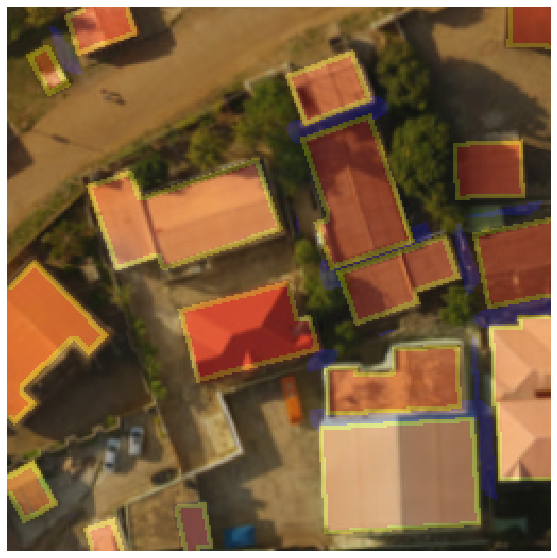

In [8]:
# test that masks are opening correctly with open_mask() settings
img_f = 120
img = open_image(filepath_df.iloc[img_f][0])
mask = open_mask(filepath_df.iloc[img_f][1], convert_mode='RGB', div=False)

fig, ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.2)

(array([165849.,      0.,  30759.]),
 array([  0.,  85., 170., 255.]),
 <a list of 3 Patch objects>)

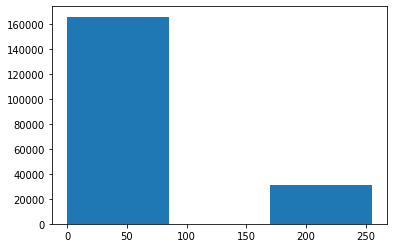

In [9]:
plt.hist(mask.data.view(-1), bins=3)

In [10]:
# define the valdation set by file name prefix
holdout_grids = ['acc665946validation_']
valid_idx = [i for i,o in enumerate(filepath_df.img_path) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))

88


In [11]:
filepath_df['valid']=False
filepath_df.loc[valid_idx, 'valid'] = True

In [12]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [13]:
# the classes corresponding to each channel
codes = np.array(['Footprint','Boundary','Contact'])
size = 256
bs = 16

In [14]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)



src = (SegmentationItemList.from_df(path='', df=filepath_df, cols='img_path')
       .split_from_df(col='valid')
       .label_from_df(cols='mask_path', classes=codes))



data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [15]:
data

ImageDataBunch;

Train: LabelList (371 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Valid: LabelList (88 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Test: None

### Using file_idx_lists instead of dataframes:

In [18]:
path = Path('../../data/processed/')
path.ls()

[PosixPath('../../data/processed/masks-256-acc-665946'),
 PosixPath('../../data/processed/images-256-acc-665946')]

In [19]:
path_lbl = path/'masks-256-acc-665946'
path_img = path/'images-256-acc-665946'

In [20]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3] 

459 459


([PosixPath('../../data/processed/images-256-acc-665946/acc665946train_19_261805_253917.png'),
  PosixPath('../../data/processed/images-256-acc-665946/acc665946train_19_261799_253913.png'),
  PosixPath('../../data/processed/images-256-acc-665946/acc665946train_19_261799_253907.png')],
 [PosixPath('../../data/processed/masks-256-acc-665946/acc665946train_19_261806_253917_mask.png'),
  PosixPath('../../data/processed/masks-256-acc-665946/acc665946validation_19_261807_253940_mask.png'),
  PosixPath('../../data/processed/masks-256-acc-665946/acc665946validation_19_261807_253941_mask.png')])

In [21]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask.png'

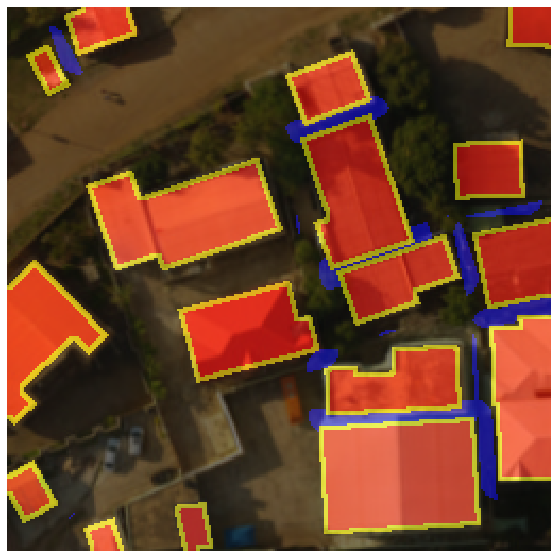

In [23]:
# test that masks are opening correctly with open_mask() settings
img_f = fnames[120]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [24]:
# define the valdation set by fn prefix
holdout_grids = ['cc665946validation_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))

88


In [25]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [27]:
# the classes corresponding to each channel
codes = np.array(['Footprint','Boundary','Contact'])

size = 256
bs = 16

In [28]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

src = (SegItemListCustom.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
data

ImageDataBunch;

Train: LabelList (371 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: ../../data/processed/images-256-acc-665946;

Valid: LabelList (88 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: ../../data/processed/images-256-acc-665946;

Test: None

In [30]:
def show_3ch(imgitem, figsize=(10,5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    ax1.imshow(np.asarray(imgitem.data[0,None])[0])
    ax2.imshow(np.asarray(imgitem.data[1,None])[0])
    ax3.imshow(np.asarray(imgitem.data[2,None])[0])
    
    ax1.set_title('Footprint')
    ax2.set_title('Boundary')
    ax3.set_title('Contact')
    
    plt.show()

../../data/processed/images-256-acc-665946/acc665946validation_19_261805_253937.png


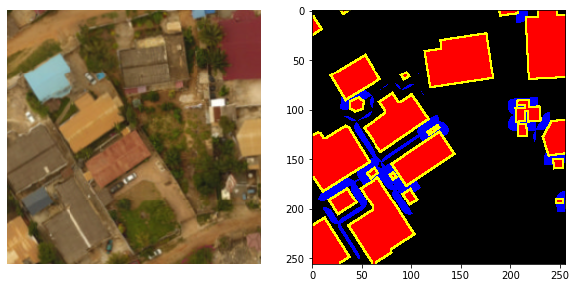

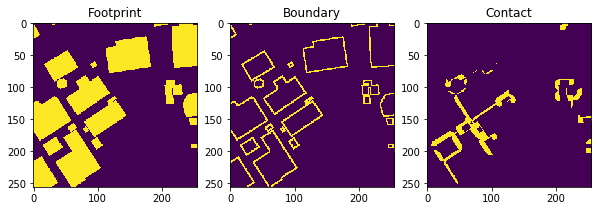

../../data/processed/images-256-acc-665946/acc665946validation_19_261805_253936.png


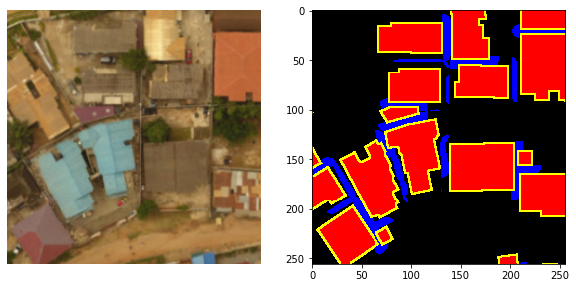

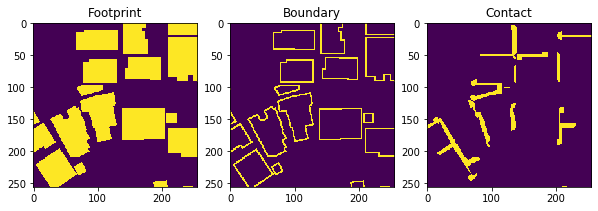

../../data/processed/images-256-acc-665946/acc665946validation_19_261806_253938.png


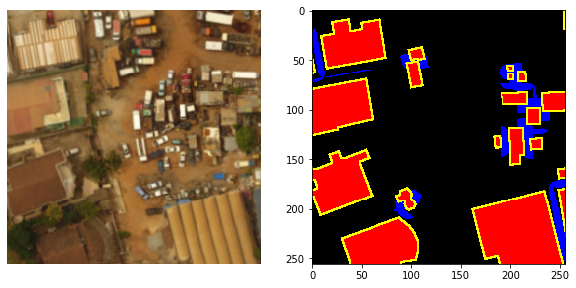

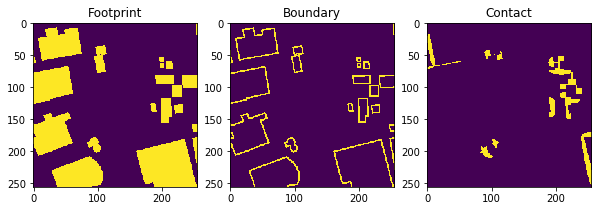

../../data/processed/images-256-acc-665946/acc665946validation_19_261807_253940.png


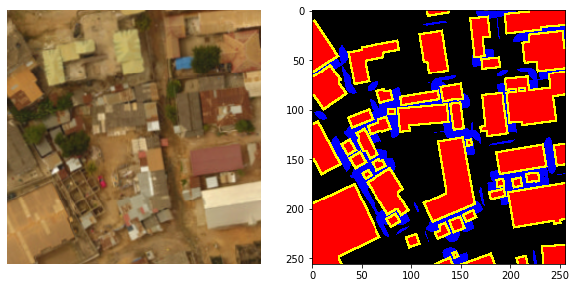

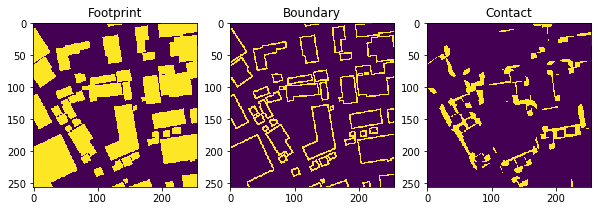

../../data/processed/images-256-acc-665946/acc665946validation_19_261808_253935.png


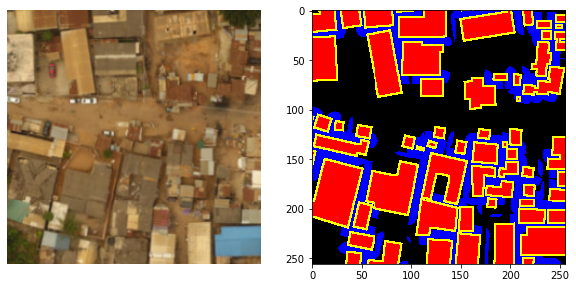

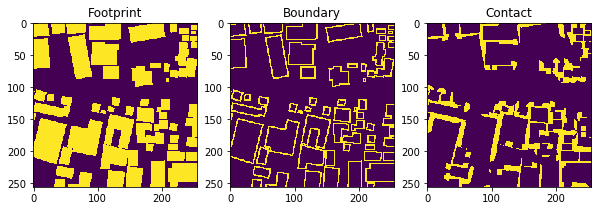

In [31]:
for idx in range(10,15):
    print(data.valid_ds.items[idx])
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    data.valid_ds.x[idx].show(ax=ax1)
    ax2.imshow(image2np(data.valid_ds.y[idx].data*255))
    plt.show()
    show_3ch(data.valid_ds.y[idx])

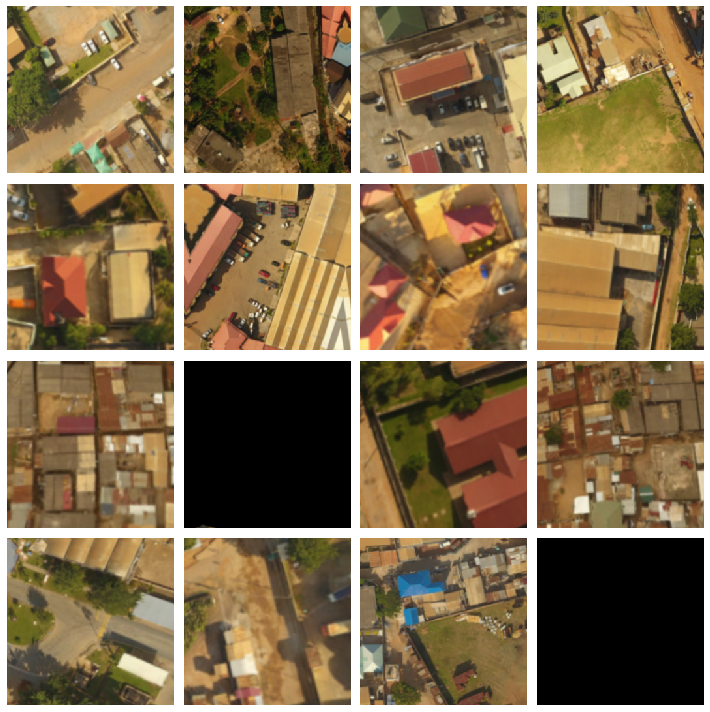

In [32]:
data.show_batch(4,figsize=(10,10), alpha=0.)

### Define custom losses and metrics

In [33]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [34]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

### Set up the model

## Set up model

We'll set up fastai's Dynamic Unet model with an ImageNet-pretrained resnet34 encoder. This architecture, inspired by the original U-net, uses by default many advanced deep learning techniques such as:

- One cycle learning schedule: https://sgugger.github.io/the-1cycle-policy.html
- AdamW optimizer: https://www.fast.ai/2018/07/02/adam-weight-decay/
- Pixel shuffle upsampling with ICNR initiation from super resolution research: https://medium.com/@hirotoschwert/introduction-to-deep-super-resolution-c052d84ce8cf
- Optionally set leaky ReLU, blur, self attention: https://docs.fast.ai/vision.models.unet.html#DynamicUnet

We'll define our `MultiChComboLoss` function as a balanced combination of Focal Loss and Dice Loss and set our accuracy and dice metrics. 

Also note that our metrics displayed during training shows channel-0 (building footprint channel only) accuracy and dice metrics in the right-most 2 columns while the first two accuracy and dice metrics (left-hand columns) show the mean of the respective metric across all 3 channels.

In [35]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)

acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [36]:
# combo Focal + Dice loss with equal channel wts

learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

In [37]:
learn.metrics

[<function __main__.acc_thresh_multich(input: torch.Tensor, target: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True, one_ch: int = None) -> <function NewType.<locals>.new_type at 0x11cbfadd0>>,
 <function __main__.dice_multich(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, one_ch: int = None) -> <function NewType.<locals>.new_type at 0x11cbfadd0>>,
 functools.partial(<function acc_thresh_multich at 0x1385b73b0>, one_ch=0),
 functools.partial(<function dice_multich at 0x1385b7200>, one_ch=0)]

In [38]:
learn.loss_func

MultiChComboLoss()

In [39]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

## Train model, inspect results, unfreeze & train more, export for inference

First, we'll fine-tune our Unet on the decoder part only (leaving the weights for the ImageNet-pretrained resnet34 encoder frozen) for some epochs. Then we'll unfreeze all the trainable weights/layers of our model and train for some more epochs.

We'll track the `valid_loss`, `acc_...`, and `dice_..`. metrics per epoch as training progresses to make sure they continue to improve and we're not overfitting. And we set a `SaveModelCallback` which will track the channel-0 dice score, save a model checkpoint each time there's an improvement, and reload the highest performing model checkpoint file at the end of training.

We'll also inspect our model's results by setting `learn.model.eval()`, generating some batches of predictions on the validation set, calculating and reshaping the image-wise loss values, and sorting by highest loss first to see the worst performing results (as measured by the loss which may differ in surprising ways from visually gauging results). 

**Pro-tip:** display and view your results every chance you get! You'll pick up on all kinds of interesting clues about your model's behavior and how to make it better.

Finally, we'll export our trained Unet segmentation model for inference purposes as a `.pkl` file. Learn more about exporting fastai models for inference in this tutorial: https://docs.fast.ai/tutorial.inference.html

In [40]:
learn.lr_find()

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/User

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.92E-07


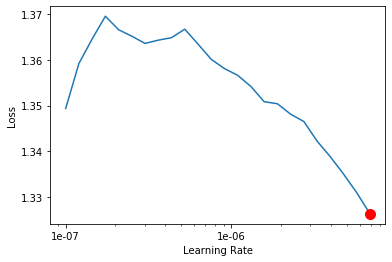

In [41]:
learn.recorder.plot(0,2,suggestion=True)

In [42]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best')
                    ]
                   )

NameError: name 'SaveModelCallback' is not defined